In [33]:
import librosa
import numpy as np
import os
import math
from sklearn.cluster import KMeans
import hmmlearn.hmm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pickle

## Get MFCC function

In [34]:
# read file
def get_mfcc(file_path):
    y, sr = librosa.load(file_path) # read .wav file
    hop_length = math.floor(sr*0.010) # 10ms hop
    win_length = math.floor(sr*0.025) # 25ms frame
    # mfcc is 12 x T matrix
    mfcc = librosa.feature.mfcc(
        y, sr, n_mfcc=12, n_fft=1024,
        hop_length=hop_length, win_length=win_length)
    # substract mean from mfcc --> normalize mfcc
    mfcc = mfcc - np.mean(mfcc, axis=1).reshape((-1,1)) 
    # delta feature 1st order and 2nd order
    delta1 = librosa.feature.delta(mfcc, order=1)
    delta2 = librosa.feature.delta(mfcc, order=2)
    # X is 36 x T
    X = np.concatenate([mfcc, delta1, delta2], axis=0) # O^r
    # return T x 36 (transpose of X)
    return X.T # hmmlearn use T x N matrix

## lấy mfcc của tất cả các file trong dir

In [35]:
# lấy mfcc của tất cả các file wav trong wav
def get_class_data(data_dir):
    files = os.listdir(data_dir)
    mfcc = [get_mfcc(os.path.join(data_dir,f)) for f in files if f.endswith(".wav")]
    return mfcc

## Hàm Clustering

In [36]:
def clustering(X, n_clusters=14):
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0, verbose=0)
    kmeans.fit(X)
    print("centers", kmeans.cluster_centers_.shape)
    return kmeans

## plot biểu đồ predict/true

In [37]:
def plotCM(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('test')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.show()

## Data

In [42]:
class_names = ['len', 'xuong', 'trai', 'phai']
dataset = {}
for cname in class_names:
    print(f"Load {cname} dataset")
    dataset[cname]=get_class_data(os.path.join('data',cname))

Load len dataset
Load xuong dataset
Load trai dataset
Load phai dataset


In [43]:
print(len(dataset['len']))
print(len(dataset['xuong']))
print(len(dataset['trai']))
print(len(dataset['phai']))

101
102
102
102


In [44]:
"""
testClass_names = ['len', 'xuong', 'trai', 'phai']
n_testDataSet = {'len': 0, 'xuong': 0, 'trai': 0, 'phai': 0}
testDataSet = {}
for cname in testClass_names:
    print(f"Load {cname} testDataSet")
    testDataSet[cname] = get_class_data(os.path.join('test', cname))
    n_testDataSet[cname] = len(testDataSet[cname])
print(len(testDataSet['len']))
print(len(testDataSet['xuong']))
print(len(testDataSet['trai']))
print(len(testDataSet['phai']))
print(n_testDataSet)
"""

Load len testDataSet


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'test\\len'

## split train test

In [49]:
trainset = {}
testset = {}
n_test = {'len': 0, 'xuong': 0, 'trai': 0, 'phai': 0}
for cname in class_names:
    n = len(dataset[cname])
    n_train = math.floor(n*0.8)
    trainset[cname] = dataset[cname][:n_train]
    testset[cname] = dataset[cname][n_train:]
    n_test[cname] += len(testset[cname])
    
print(len(trainset['len']))
print(len(trainset['xuong']))
print(len(trainset['trai']))
print(len(trainset['phai']))


80
81
81
81


## Fit kmeans trên tập train

In [50]:
# Get all vectors in the datasets
all_vectors = np.concatenate([np.concatenate(v, axis=0) for k, v in trainset.items()], axis=0)
print("vectors", all_vectors.shape)
# Run K-Means algorithm to get clusters
kmeans = clustering(all_vectors)
print("centers", kmeans.cluster_centers_.shape)
print(kmeans)
fileNameKmeans = 'kmeans.sav'
pickle.dump(kmeans, open(fileNameKmeans, 'wb'))

vectors (23819, 36)
centers (14, 36)
centers (14, 36)
KMeans(n_clusters=14, n_init=50, random_state=0)


In [51]:
for cname in class_names:
    trainset[cname] = list([kmeans.predict(v).reshape(-1, 1) for v in trainset[cname]])
    testset[cname] = list([kmeans.predict(v).reshape(-1, 1) for v in testset[cname]])
#for cname in testClass_names:
 #   testDataSet[cname] = list([kmeans.predict(v).reshape(-1, 1) for v in testDataSet[cname]])
    
    

# Train

In [52]:
models = {}

## Models cho 'xuống' 4x3

In [53]:
hmm = hmmlearn.hmm.MultinomialHMM(n_components=4*3, random_state=0, n_iter=1000, verbose=True, init_params='e', params='ste')
hmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ])
hmm.transmat_ =np.array([
    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ],])


Xbn = np.concatenate(trainset['xuong'])
lengths = list([len(x) for x in trainset['xuong']])
print("training class", 'xuong')
print(Xbn.shape, lengths, len(lengths))
hmm.fit(Xbn, lengths=lengths)
models['xuong'] = hmm
print("Training done")

training class xuong
(5843, 1) [73, 80, 34, 71, 82, 65, 82, 90, 89, 75, 80, 78, 73, 84, 81, 80, 84, 67, 77, 113, 89, 76, 89, 78, 66, 48, 59, 60, 51, 58, 55, 50, 61, 47, 74, 53, 52, 71, 80, 84, 91, 98, 96, 96, 98, 89, 101, 68, 76, 108, 152, 84, 82, 96, 84, 96, 103, 89, 89, 62, 103, 42, 103, 96, 91, 36, 36, 35, 42, 39, 62, 46, 40, 39, 42, 42, 46, 54, 47, 46, 39] 81


         1      -14690.6885             +nan
         2       -9373.8555       +5316.8330
         3       -7927.1577       +1446.6978
         4       -7463.5387        +463.6190
         5       -7320.7134        +142.8253
         6       -7142.8080        +177.9054
         7       -7085.7954         +57.0126
         8       -7065.3747         +20.4208
         9       -7055.5934          +9.7813
        10       -7037.7393         +17.8541
        11       -7007.4731         +30.2662
        12       -7003.7408          +3.7323
        13       -7001.4272          +2.3136
        14       -6999.5784          +1.8488
        15       -6998.3665          +1.2119
        16       -6997.5752          +0.7913
        17       -6996.9676          +0.6076
        18       -6996.4114          +0.5562
        19       -6995.8268          +0.5846
        20       -6995.1467          +0.6800
        21       -6994.2846          +0.8621
        22       -6993.0610          +1.2236
        23

Training done


        58       -6932.2607          +0.0273
        59       -6932.2444          +0.0163
        60       -6932.2346          +0.0098


## Models cho 'đã' 2x3

In [54]:
"""
hmm = hmmlearn.hmm.MultinomialHMM(n_components=2*3, random_state=0, n_iter=1000, verbose=True, init_params='e', params='ste')
hmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0 ])
hmm.transmat_ =np.array([
    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0],
    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0],
    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0],
    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1],
    [0.0, 0.0, 0.0, 0.0, 0.7, 0.3],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],])

Xct = np.concatenate(trainset['da'])
lengths = list([len(x) for x in trainset['da']])
print("training class", 'da')
print(Xct.shape, lengths, len(lengths))
hmm.fit(Xct, lengths=lengths)
models['da'] = hmm
print("Training done")"""

'\nhmm = hmmlearn.hmm.MultinomialHMM(n_components=2*3, random_state=0, n_iter=1000, verbose=True, init_params=\'e\', params=\'ste\')\nhmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0 ])\nhmm.transmat_ =np.array([\n    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0],\n    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0],\n    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0],\n    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1],\n    [0.0, 0.0, 0.0, 0.0, 0.7, 0.3],\n    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],])\n\nXct = np.concatenate(trainset[\'da\'])\nlengths = list([len(x) for x in trainset[\'da\']])\nprint("training class", \'da\')\nprint(Xct.shape, lengths, len(lengths))\nhmm.fit(Xct, lengths=lengths)\nmodels[\'da\'] = hmm\nprint("Training done")'

## Models cho 'lên' 3x3

In [55]:
hmm = hmmlearn.hmm.MultinomialHMM(n_components=3*3, random_state=0, n_iter=1000, verbose=True, init_params='e', params='ste')
hmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ])
hmm.transmat_ =np.array([
    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ],])

Xvn = np.concatenate(trainset['len'])
lengths = list([len(x) for x in trainset['len']])
print("training class", 'len')
print(Xvn.shape, lengths, len(lengths))
hmm.fit(Xvn, lengths=lengths)
models['len'] = hmm
print("Training done")

training class len
(6185, 1) [55, 63, 27, 70, 61, 62, 75, 69, 58, 63, 62, 62, 58, 63, 62, 73, 56, 71, 59, 81, 107, 107, 73, 60, 81, 47, 44, 56, 46, 45, 58, 48, 45, 46, 69, 51, 43, 60, 55, 50, 53, 50, 133, 175, 129, 140, 131, 61, 133, 140, 147, 124, 147, 156, 161, 156, 182, 217, 65, 129, 145, 147, 173, 147, 23, 22, 24, 26, 33, 70, 25, 28, 27, 31, 28, 27, 31, 38, 39, 31] 80


         1      -16152.5363             +nan
         2      -11233.1910       +4919.3453
         3       -9305.0512       +1928.1398
         4       -8743.4833        +561.5679
         5       -8528.4070        +215.0764
         6       -8391.9228        +136.4842
         7       -8283.3544        +108.5683
         8       -8156.8182        +126.5363
         9       -7960.2899        +196.5282
        10       -7910.7761         +49.5138
        11       -7899.7031         +11.0730
        12       -7892.7062          +6.9969
        13       -7887.8117          +4.8945
        14       -7884.6416          +3.1701
        15       -7883.0061          +1.6355
        16       -7882.3424          +0.6637
        17       -7881.9882          +0.3542
        18       -7881.7584          +0.2298
        19       -7881.6035          +0.1549
        20       -7881.4978          +0.1057
        21       -7881.4222          +0.0756
        22       -7881.3609          +0.0613
        23

Training done


        40       -7879.0351          +0.0132
        41       -7879.0262          +0.0089


## Models cho 'trái' 3x3

In [56]:
hmm = hmmlearn.hmm.MultinomialHMM(n_components=3*3, random_state=0, n_iter=1000, verbose=True, init_params='e', params='ste')
hmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ])
hmm.transmat_ =np.array([
    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ],])

Xvn = np.concatenate(trainset['trai'])
lengths = list([len(x) for x in trainset['trai']])
print("training class", 'trai')
print(Xvn.shape, lengths, len(lengths))
hmm.fit(Xvn, lengths=lengths)
models['trai'] = hmm
print("Training done")

         1      -14682.8197             +nan


training class trai
(5804, 1) [73, 76, 43, 74, 71, 77, 75, 69, 76, 70, 68, 77, 69, 80, 71, 71, 80, 80, 76, 71, 73, 68, 63, 71, 84, 47, 42, 64, 44, 47, 51, 44, 50, 43, 73, 47, 45, 68, 112, 103, 108, 101, 96, 101, 117, 108, 103, 101, 66, 96, 96, 103, 101, 96, 96, 110, 96, 103, 101, 75, 103, 117, 108, 103, 108, 38, 30, 36, 33, 36, 77, 33, 33, 41, 38, 33, 40, 36, 32, 33, 36] 81


         2      -10245.3486       +4437.4711
         3       -8704.6575       +1540.6911
         4       -8063.7431        +640.9144
         5       -7431.1102        +632.6329
         6       -7240.9108        +190.1994
         7       -7185.9511         +54.9597
         8       -7165.6644         +20.2867
         9       -7144.0311         +21.6333
        10       -7125.6708         +18.3603
        11       -7115.0535         +10.6172
        12       -7110.7885          +4.2651
        13       -7109.5399          +1.2486
        14       -7109.2493          +0.2906
        15       -7109.1835          +0.0658
        16       -7109.1621          +0.0214
        17       -7109.1472          +0.0149
        18       -7109.1273          +0.0198
        19       -7109.0919          +0.0354
        20       -7109.0201          +0.0718
        21       -7108.8624          +0.1578
        22       -7108.5062          +0.3562
        23       -7107.6626          +0.8435
        24

Training done


        33       -7079.4555          +0.1086
        34       -7079.4307          +0.0248
        35       -7079.4253          +0.0054


## Models cho 'phải' 4x3

In [57]:
hmm = hmmlearn.hmm.MultinomialHMM(n_components=3*3, random_state=0, n_iter=1000, verbose=True, init_params='e', params='ste')
hmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ])
hmm.transmat_ =np.array([
    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ],])

Xvn = np.concatenate(trainset['phai'])
lengths = list([len(x) for x in trainset['phai']])
print("training class", 'phai')
print(Xvn.shape, lengths, len(lengths))
hmm.fit(Xvn, lengths=lengths)
models['phai'] = hmm
print("Training done")

training class phai
(5987, 1) [73, 78, 44, 78, 77, 77, 83, 77, 85, 78, 102, 88, 81, 89, 73, 75, 81, 89, 66, 79, 81, 97, 73, 71, 97, 53, 39, 65, 47, 44, 44, 46, 53, 39, 71, 38, 30, 74, 103, 89, 96, 108, 119, 112, 101, 103, 108, 101, 73, 103, 112, 96, 91, 108, 103, 108, 108, 101, 103, 71, 103, 108, 103, 103, 112, 37, 34, 37, 37, 35, 71, 35, 30, 35, 34, 35, 35, 42, 35, 39, 35] 81


         1      -15210.8189             +nan
         2      -11044.7449       +4166.0740
         3       -9451.3646       +1593.3802
         4       -9193.3172        +258.0475
         5       -9129.7116         +63.6056
         6       -9080.9648         +48.7468
         7       -9015.9358         +65.0290
         8       -8867.5483        +148.3875
         9       -8799.7129         +67.8354
        10       -8790.0517          +9.6612
        11       -8786.3037          +3.7480
        12       -8781.1020          +5.2017
        13       -8772.8043          +8.2977
        14       -8768.0218          +4.7826
        15       -8761.3090          +6.7128
        16       -8752.7842          +8.5248
        17       -8743.7396          +9.0445
        18       -8731.3986         +12.3411
        19       -8710.7355         +20.6630
        20       -8681.1983         +29.5372
        21       -8665.9977         +15.2006
        22       -8642.7880         +23.2097
        23

Training done


        45       -8565.1266          +0.0264
        46       -8565.1184          +0.0082


## Models cho 'trong' 3x3

In [58]:
"""
hmm = hmmlearn.hmm.MultinomialHMM(n_components=3*3, random_state=0, n_iter=1000, verbose=True, init_params='e', params='ste')
hmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ])
hmm.transmat_ =np.array([
    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ],])

Xvn = np.concatenate(trainset['trong'])
lengths = list([len(x) for x in trainset['trong']])
print("training class", 'trong')
print(Xvn.shape, lengths, len(lengths))
hmm.fit(Xvn, lengths=lengths)
models['trong'] = hmm
print("Training done")
"""

'\nhmm = hmmlearn.hmm.MultinomialHMM(n_components=3*3, random_state=0, n_iter=1000, verbose=True, init_params=\'e\', params=\'ste\')\nhmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ])\nhmm.transmat_ =np.array([\n    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],\n    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ],\n    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, ],\n    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, ],\n    [0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, ],\n    [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, ],\n    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, ],\n    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, ],\n    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ],])\n\nXvn = np.concatenate(trainset[\'trong\'])\nlengths = list([len(x) for x in trainset[\'trong\']])\nprint("training class", \'trong\')\nprint(Xvn.shape, lengths, len(lengths))\nhmm.fit(Xvn, lengths=lengths)\nmodels[\'trong\'] = hmm\nprint("Training done")\n'

In [59]:
fileName = 'finalModel.sav'
pickle.dump(models, open(fileName, 'wb'))

# Test

In [60]:
print("Testing")
n_correct = {'len': 0, 'xuong': 0, 'trai': 0, 'phai': 0}
y_true = []
y_predict = []
labels = ['len', 'xuong', 'trai', 'phai']
for true_cname in class_names:
    for O in testset[true_cname]:
        score = {cname: model.score(O, [len(O)]) for cname, model in models.items()}
        if (true_cname == max(score, key=score.get)): n_correct[true_cname] += 1
        y_true.append(true_cname)
        y_predict.append(max(score, key = score.get))
        print(true_cname, score, 'predict:', max(score, key=score.get))

Testing
len {'xuong': -95.55740760673186, 'len': -63.16441434228789, 'trai': -105.92515600393335, 'phai': -85.58805907082504} predict: len
len {'xuong': -58.33229648440963, 'len': -54.69569274079389, 'trai': -42.70947649028012, 'phai': -45.05165169679732} predict: trai
len {'xuong': -62.21143166278853, 'len': -53.598039213859565, 'trai': -47.5804933175083, 'phai': -48.202711161621636} predict: trai
len {'xuong': -67.16802635122575, 'len': -50.12140452333445, 'trai': -71.59969541926826, 'phai': -60.34240370743968} predict: len
len {'xuong': -52.837010458566354, 'len': -41.89652948567186, 'trai': -46.77743367338162, 'phai': -43.78712491534302} predict: len
len {'xuong': -52.829338725348634, 'len': -43.99436197176178, 'trai': -53.70396881143902, 'phai': -46.46415170690586} predict: len
len {'xuong': -51.62109206554469, 'len': -44.249365397247416, 'trai': -49.24862276225051, 'phai': -42.24021182648359} predict: phai
len {'xuong': -47.95142988364638, 'len': -38.40275676520942, 'trai': -46.2

In [61]:
for cname in class_names:
    print('Accuracy:', cname, n_correct[cname]/n_test[cname])

Accuracy: len 0.6666666666666666
Accuracy: xuong 0.5238095238095238
Accuracy: trai 0.8095238095238095
Accuracy: phai 0.047619047619047616


In [62]:
print('All Accuracy:', sum(n_correct.values())/sum(n_test.values()))

All Accuracy: 0.5119047619047619


C:\Users\Admin\miniconda3\envs\voice\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=['len', 'xuong', 'trai', 'phai'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


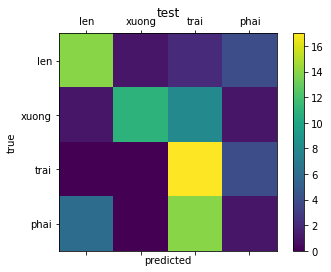

In [63]:
plotCM(y_true, y_predict, labels)

In [64]:
print(n_test)

{'len': 21, 'xuong': 21, 'trai': 21, 'phai': 21}


## Test âm thu từ micro

In [ ]:
print("Testing testDataSet")
n_correct = {'len': 0, 'xuong': 0, 'trai': 0, 'phai': 0}
y_testTrue = []
y_testPredict = []
labels = ['trai', 'len', 'xuong', 'phai']
for true_cname in testClass_names:
    for O in testDataSet[true_cname]:
        score = {cname: model.score(O, [len(O)]) for cname, model in models.items()}
        if (true_cname == max(score, key=score.get)): n_correct[true_cname] += 1
        y_testTrue.append(true_cname)
        y_testPredict.append(max(score, key = score.get))
        print(true_cname, score, 'predict:', max(score, key=score.get))

In [ ]:
#np.around(models['trong'].transmat_, 2)

In [ ]:
for cname in testClass_names:
    print('Accuracy:', cname, n_correct[cname]/n_testDataSet[cname])
print('All Accuracy:', sum(n_correct.values())/sum(n_testDataSet.values()))

In [ ]:
plotCM(y_testTrue, y_testPredict, labels)